<a href="https://colab.research.google.com/github/KirstenC32/Prediction-of-Product-Sales/blob/main/Sales_Predictions_Part_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#(Core) Project 1 - Part 8

##Task

For this assignment, you will revisit your models to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions. Then you will update your README with these insights.

###Imports

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor # NEW
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.ensemble import BaggingRegressor

###Data

In [2]:
fpath = "/content/drive/MyDrive/StudentFolders16wk24wk/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
df = pd.read_csv(fpath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [3]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


###Functions

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

##Data Cleaning

In [5]:
#I noticed errors in 'Item Fat Content'
#I will replace LF and low fat with Low Fat, and reg to Regular
df["Item_Fat_Content"] = df['Item_Fat_Content'].replace({"reg" : "Regular", "LF" : "Low Fat", "low fat" : "Low Fat"})
#Confirm changes
df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
## Display column names and datatypes
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [9]:
null_count = df.isna().sum()
null_count

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

###Train Test Split

In [10]:
y = df["Item_Outlet_Sales"]
X = df.drop(columns = ['Item_Outlet_Sales', 'Item_Identifier', 'Item_Weight'])

In [11]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


##Preprocessing

In [13]:
# Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
# set pandas to display more columns
pd.set_option('display.max_columns',50)

###Cat pipe

In [14]:
# make list of categorical columns
ohe_cols = X_train.select_dtypes('object').columns

# instantiate preprocessors
impute_constant = SimpleImputer(strategy='constant', fill_value= 'MISSING')
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# make pipeline for categorical data
ohe_pipe = make_pipeline(impute_constant, ohe_encoder)

# make tuple for column transformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

###Num Pipe

In [15]:
# make list of numeric columns
num_cols = X_train.select_dtypes('number').columns

# instantiate preproecessors
impute_mean =(SimpleImputer(strategy='mean'))

# make pipeline for numerical data
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

# make tuple for column transfomer
num_tuple = ('numeric', num_pipe, num_cols)

###Preprocessor

In [16]:
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [17]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [18]:
# Transform the X_train and the X_test
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

In [19]:
# Display the first (5) rows of the dataframe
display(X_train_proc.head())

# Check the shape
print(f'\nshape of processed data is: {X_train_proc.shape}')

# Check for remaining missing values
print(f'\nThere are {X_train_proc.isna().sum().sum()} missing values')

# Check the data types
print(f'\nThe datatypes are {X_train_proc.dtypes}')

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.029565,256.4646,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.000000,179.7660,2009.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,0.158716,157.2946,1999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,0.014628,82.3250,2004.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,0.016645,120.9098,2002.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0



shape of processed data is: (6392, 42)

There are 0 missing values

The datatypes are Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Ide

In [21]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax


##LinearRegression

Extract and visualize the coefficients that your model determined.
- Select the top 3 most impactful features and interpret their coefficients in plain English.

Save your figure as a .png file to upload to your README on GitHub  (you will need this for the final piece of this assignment - Update Your README).

In [52]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)


In [16]:
from sklearn.linear_model import LinearRegression

In [22]:
## Create an instance of the model
lin_reg = LinearRegression()

## Fit the model
lin_reg.fit(X_train_proc, y_train)

LinearRegression()

In [23]:
## Display the Model's metrics
evaluate_regression(lin_reg, X_train_proc, y_train,
                    X_test_proc, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.166
- MSE = 1,297,624.294
- RMSE = 1,139.133
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.018
- MSE = 1,194,032.957
- RMSE = 1,092.718
- R^2 = 0.567


In [24]:
## Display the model's coefficients
lin_reg.coef_

array([-421.01379074,   15.71919948,  -15.27311954,  -31.42566522,
         31.42566522,  -18.14912461,  -45.22284328,   26.60243265,
          9.36843548, -126.02904344,  -20.48211751,   26.63710313,
         -2.60644715,    8.07380304,  -14.13779426,  -31.31137395,
        -47.08759448,  309.62721582,  -40.79571274,  -56.41278967,
         21.92585098, -426.11547927,  -67.42535305,  198.02280687,
        -82.48266158, -469.82300232,  588.27684831,   62.02518048,
        -19.53243224,  301.51171822,  -84.45762542,  -67.42535305,
       -247.62510463,  421.33656131, -106.28610362, -252.76890953,
        240.51555512,   12.25335441, -895.93848159,  390.14429486,
        -82.48266158,  588.27684831])

In [25]:
## Display the model's intercept
lin_reg.intercept_

30257.67044616704

In [26]:
## Saving the coefficients
coef_series = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
coef_series

Item_Visibility                   -421.013791
Item_MRP                            15.719199
Outlet_Establishment_Year          -15.273120
Item_Fat_Content_Low Fat           -31.425665
Item_Fat_Content_Regular            31.425665
Item_Type_Baking Goods             -18.149125
Item_Type_Breads                   -45.222843
Item_Type_Breakfast                 26.602433
Item_Type_Canned                     9.368435
Item_Type_Dairy                   -126.029043
Item_Type_Frozen Foods             -20.482118
Item_Type_Fruits and Vegetables     26.637103
Item_Type_Hard Drinks               -2.606447
Item_Type_Health and Hygiene         8.073803
Item_Type_Household                -14.137794
Item_Type_Meat                     -31.311374
Item_Type_Others                   -47.087594
Item_Type_Seafood                  309.627216
Item_Type_Snack Foods              -40.795713
Item_Type_Soft Drinks              -56.412790
Item_Type_Starchy Foods             21.925851
Outlet_Identifier_OUT010          

In [27]:
## Add the Intercept
coef_series['intercept'] = lin_reg.intercept_
coef_series

Item_Visibility                     -421.013791
Item_MRP                              15.719199
Outlet_Establishment_Year            -15.273120
Item_Fat_Content_Low Fat             -31.425665
Item_Fat_Content_Regular              31.425665
Item_Type_Baking Goods               -18.149125
Item_Type_Breads                     -45.222843
Item_Type_Breakfast                   26.602433
Item_Type_Canned                       9.368435
Item_Type_Dairy                     -126.029043
Item_Type_Frozen Foods               -20.482118
Item_Type_Fruits and Vegetables       26.637103
Item_Type_Hard Drinks                 -2.606447
Item_Type_Health and Hygiene           8.073803
Item_Type_Household                  -14.137794
Item_Type_Meat                       -31.311374
Item_Type_Others                     -47.087594
Item_Type_Seafood                    309.627216
Item_Type_Snack Foods                -40.795713
Item_Type_Soft Drinks                -56.412790
Item_Type_Starchy Foods               21

In [28]:
## formatting numbers to not use a , and to use thousands sep, and 4 digits floats
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")

In [64]:
# Define a function to extract linear regression coefficients
def get_coefficients(lin_reg):
    coefs = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
    coefs['intercept'] = lin_reg.intercept_
    return coefs

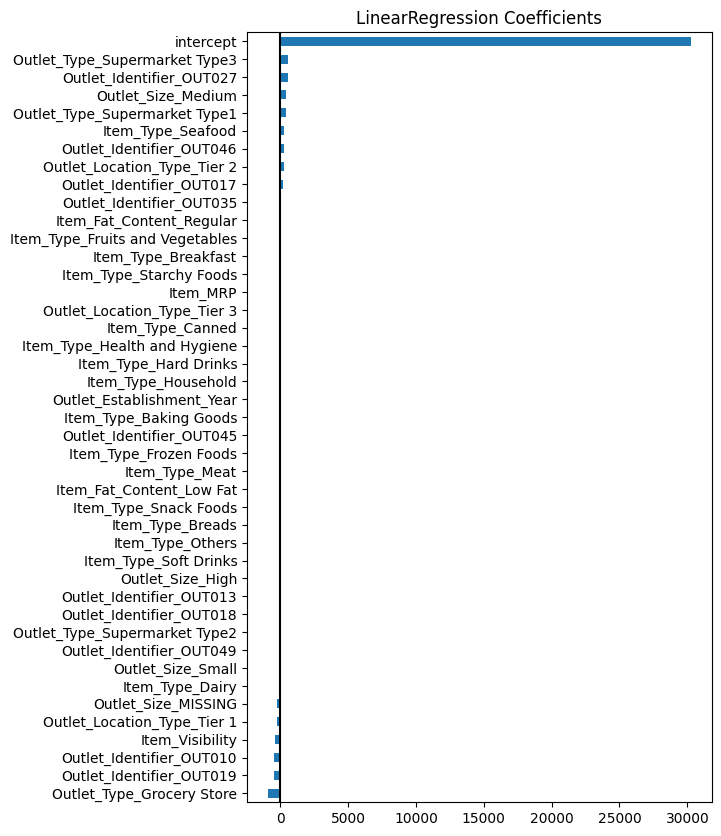

In [60]:
## Create a barplot of the coefficients
## sorted by values
ax = coef_series.sort_values().plot(kind='barh', figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

In [65]:
coeff_rank = coef_series.abs().rank().sort_values(ascending=False)
coeff_rank

intercept                         43.0000
Outlet_Type_Grocery Store         42.0000
Outlet_Type_Supermarket Type3     41.0000
Outlet_Identifier_OUT027          40.0000
Outlet_Identifier_OUT019          39.0000
Outlet_Identifier_OUT010          38.0000
Outlet_Size_Medium                37.0000
Item_Visibility                   36.0000
Outlet_Type_Supermarket Type1     35.0000
Item_Type_Seafood                 34.0000
Outlet_Identifier_OUT046          33.0000
Outlet_Location_Type_Tier 1       32.0000
Outlet_Size_MISSING               31.0000
Outlet_Location_Type_Tier 2       30.0000
Outlet_Identifier_OUT017          29.0000
Item_Type_Dairy                   28.0000
Outlet_Size_Small                 27.0000
Outlet_Identifier_OUT049          26.0000
Outlet_Type_Supermarket Type2     25.0000
Outlet_Identifier_OUT018          24.0000
Outlet_Identifier_OUT013          23.0000
Outlet_Size_High                  22.0000
Outlet_Identifier_OUT035          21.0000
Item_Type_Soft Drinks             

In [66]:
top_n_features = coeff_rank.head(10)
top_n_features



intercept                       43.0000
Outlet_Type_Grocery Store       42.0000
Outlet_Type_Supermarket Type3   41.0000
Outlet_Identifier_OUT027        40.0000
Outlet_Identifier_OUT019        39.0000
Outlet_Identifier_OUT010        38.0000
Outlet_Size_Medium              37.0000
Item_Visibility                 36.0000
Outlet_Type_Supermarket Type1   35.0000
Item_Type_Seafood               34.0000
dtype: float64

In [68]:
## Slicing out the top_n_features names to visualize
plot_vals = coef_series.loc[top_n_features.index]
plot_vals



intercept                       30,257.6704
Outlet_Type_Grocery Store         -895.9385
Outlet_Type_Supermarket Type3      588.2768
Outlet_Identifier_OUT027           588.2768
Outlet_Identifier_OUT019          -469.8230
Outlet_Identifier_OUT010          -426.1155
Outlet_Size_Medium                 421.3366
Item_Visibility                   -421.0138
Outlet_Type_Supermarket Type1      390.1443
Item_Type_Seafood                  309.6272
dtype: float64

In [71]:
top_n = 15
coeff_rank = coef_series.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coef_series.loc[top_n_features].sort_values()
plot_vals



Outlet_Type_Grocery Store         -895.9385
Outlet_Identifier_OUT019          -469.8230
Outlet_Identifier_OUT010          -426.1155
Item_Visibility                   -421.0138
Outlet_Location_Type_Tier 1       -252.7689
Outlet_Size_MISSING               -247.6251
Outlet_Identifier_OUT017           198.0228
Outlet_Location_Type_Tier 2        240.5156
Outlet_Identifier_OUT046           301.5117
Item_Type_Seafood                  309.6272
Outlet_Type_Supermarket Type1      390.1443
Outlet_Size_Medium                 421.3366
Outlet_Identifier_OUT027           588.2768
Outlet_Type_Supermarket Type3      588.2768
intercept                       30,257.6704
dtype: float64

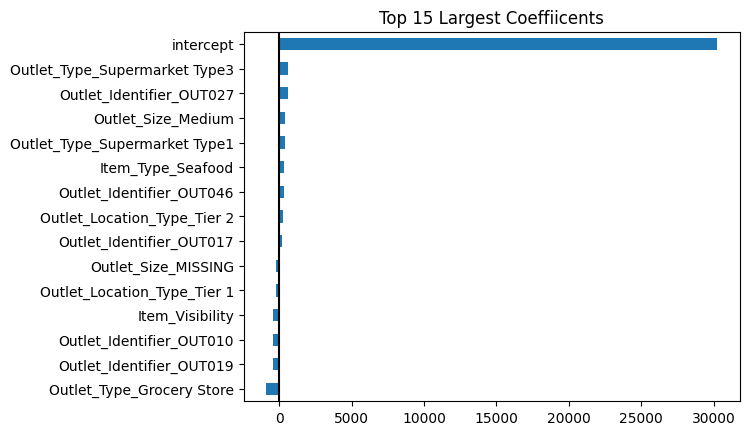

In [72]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');



In [73]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')

    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"

    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    ## return ax in case want to continue to update/modify figure
    return ax



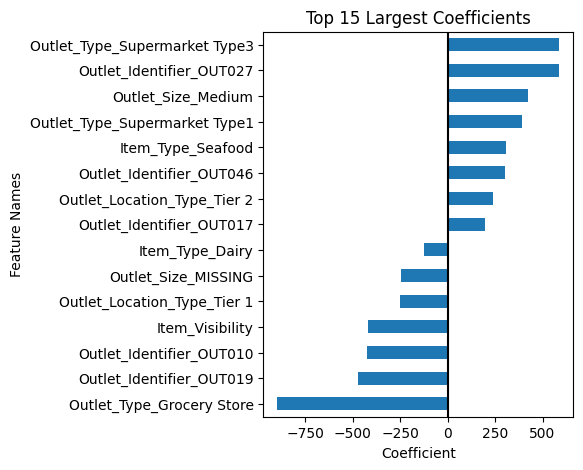

In [77]:
## Testing our function with intercept=True
ax= plot_coeffs(coef_series,top_n=15, intercept=False)



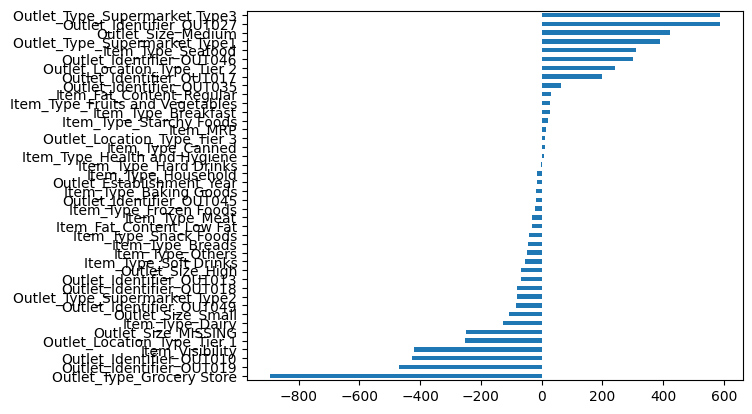

In [31]:
## Create a barplot of the coefficients
## sorted by values
## and drop the intercept
coef_series.drop('intercept').sort_values().plot(kind='barh');

In [54]:
## Define a function to plot coefficients
def plot_coefficients(coefs, drop_intercept=True):
    if drop_intercept:
        coefs = coefs.drop('intercept')
    ax = coefs.sort_values().plot(kind='barh', figsize=(5,5))
    ax.axvline(0, color='k')
    ax.set(xlabel='Product Purchase', title="Coefficients")
    plt.show();

In [55]:
## Display the coefficients series
## sorted by descending values
display(coef_series.sort_values(ascending=False))

intercept                         30,257.6704
Outlet_Type_Supermarket Type3        588.2768
Outlet_Identifier_OUT027             588.2768
Outlet_Size_Medium                   421.3366
Outlet_Type_Supermarket Type1        390.1443
Item_Type_Seafood                    309.6272
Outlet_Identifier_OUT046             301.5117
Outlet_Location_Type_Tier 2          240.5156
Outlet_Identifier_OUT017             198.0228
Outlet_Identifier_OUT035              62.0252
Item_Fat_Content_Regular              31.4257
Item_Type_Fruits and Vegetables       26.6371
Item_Type_Breakfast                   26.6024
Item_Type_Starchy Foods               21.9259
Item_MRP                              15.7192
Outlet_Location_Type_Tier 3           12.2534
Item_Type_Canned                       9.3684
Item_Type_Health and Hygiene           8.0738
Item_Type_Hard Drinks                 -2.6064
Item_Type_Household                  -14.1378
Outlet_Establishment_Year            -15.2731
Item_Type_Baking Goods            

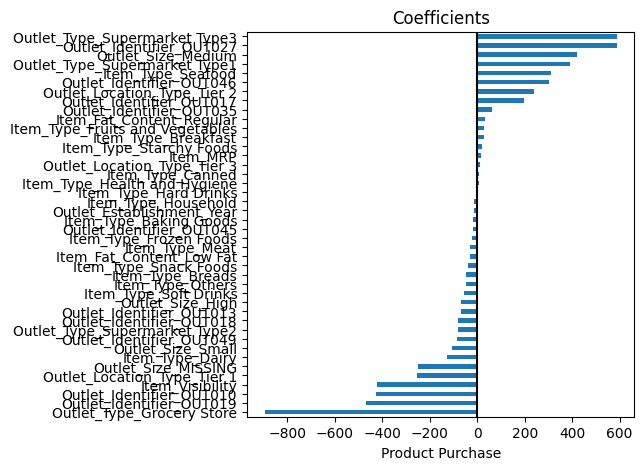

In [56]:
## Call the plot_coefficients function
plot_coefficients(coef_series)

##Tree-Based Model

Extract and visualize the feature importances that your best model determined.

- Identify the top 5 most important features.

Save your figure as a .png file to upload to your README on GitHub (you will need this for the final piece of this assignment - Update Your README).

In [35]:
## Create an instance of the model
rf_reg = RandomForestRegressor()

## Fit the model
rf_reg.fit(X_train_proc, y_train)

RandomForestRegressor()

In [36]:
## Display the Model's metrics
evaluate_regression(rf_reg, X_train_proc, y_train,
                    X_test_proc, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 298.272
- MSE = 185,149.674
- RMSE = 430.290
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 762.991
- MSE = 1,209,060.500
- RMSE = 1,099.573
- R^2 = 0.562


In [37]:
# Extract Feature Importances
importances = rf_reg.feature_importances_
importances

array([1.17225746e-01, 4.59474001e-01, 2.66590478e-02, 6.34140708e-03,
       6.38248914e-03, 5.04802186e-03, 3.30057736e-03, 3.22861744e-03,
       5.13877681e-03, 7.85257290e-03, 6.83788758e-03, 9.03851186e-03,
       3.44534004e-03, 4.65786404e-03, 7.49676291e-03, 4.40805538e-03,
       1.96242426e-03, 2.04207843e-03, 9.69927922e-03, 6.46465492e-03,
       3.75059533e-03, 1.28153193e-05, 1.75064833e-03, 3.18280010e-03,
       1.19675228e-03, 1.46871022e-05, 2.91807282e-02, 4.15061862e-03,
       4.10327672e-03, 3.52543460e-03, 2.93011636e-03, 1.80316213e-03,
       2.81117562e-03, 2.85477731e-03, 4.38074350e-03, 2.99516732e-03,
       2.59038962e-03, 2.88606115e-03, 1.91709016e-01, 1.61226176e-03,
       1.07205780e-03, 3.47825994e-02])

In [38]:
## Define a function to extract importances from a model
def get_feature_importances(model):
    importances = model.feature_importances_
    feature_names = model.feature_names_in_
    return pd.Series(importances, index=feature_names)

In [39]:
## Define a series variable by
## calling the get_feature_importances function
## to obtain importances from a model
importances =  get_feature_importances(rf_reg)
importances

Item_Visibility                   0.1172
Item_MRP                          0.4595
Outlet_Establishment_Year         0.0267
Item_Fat_Content_Low Fat          0.0063
Item_Fat_Content_Regular          0.0064
Item_Type_Baking Goods            0.0050
Item_Type_Breads                  0.0033
Item_Type_Breakfast               0.0032
Item_Type_Canned                  0.0051
Item_Type_Dairy                   0.0079
Item_Type_Frozen Foods            0.0068
Item_Type_Fruits and Vegetables   0.0090
Item_Type_Hard Drinks             0.0034
Item_Type_Health and Hygiene      0.0047
Item_Type_Household               0.0075
Item_Type_Meat                    0.0044
Item_Type_Others                  0.0020
Item_Type_Seafood                 0.0020
Item_Type_Snack Foods             0.0097
Item_Type_Soft Drinks             0.0065
Item_Type_Starchy Foods           0.0038
Outlet_Identifier_OUT010          0.0000
Outlet_Identifier_OUT013          0.0018
Outlet_Identifier_OUT017          0.0032
Outlet_Identifie

In [78]:
# Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)

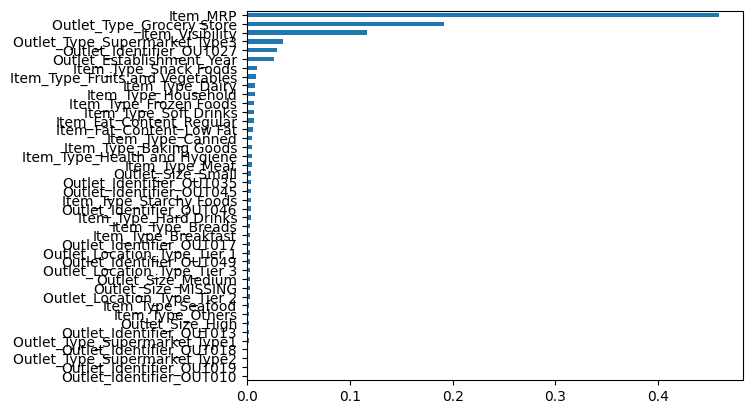

In [40]:
## Create a barplot of the importance series variable
## sorted by values
importances.sort_values().plot(kind='barh');

<Axes: >

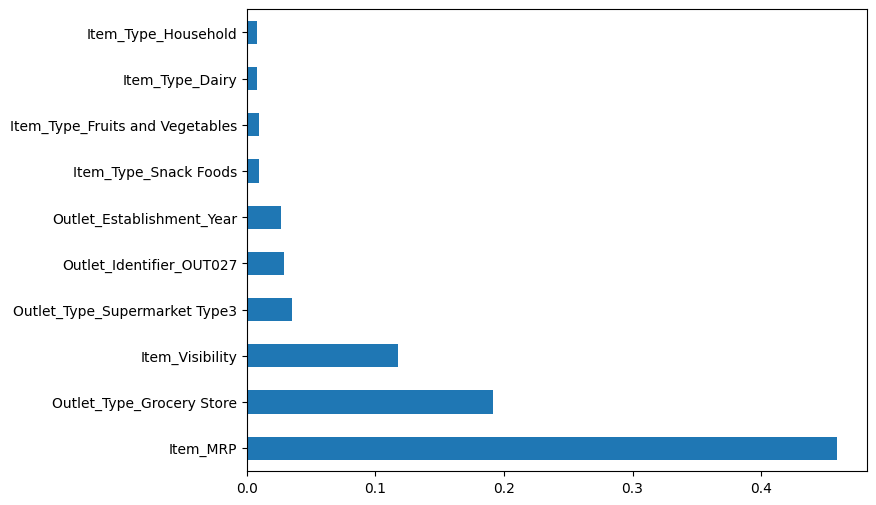

In [79]:
# just keep the top 10 importances and plot
sorted_importance.head(10).plot(kind='barh',
                                   figsize=(8,6))

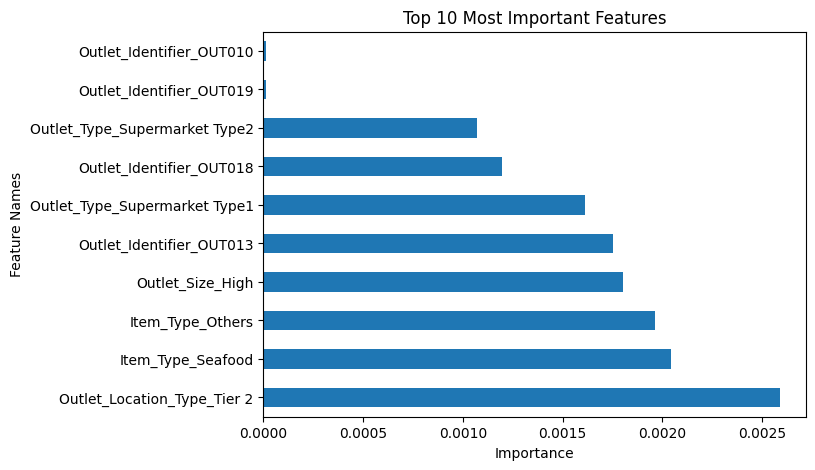

In [80]:
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

###More Exploring

In [41]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg, X_train_proc, y_train, X_test_proc, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.166
- MSE = 1,297,624.294
- RMSE = 1,139.133
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.018
- MSE = 1,194,032.957
- RMSE = 1,092.718
- R^2 = 0.567


In [42]:
## evaluate the random forest
evaluate_regression(rf_reg, X_train_proc, y_train, X_test_proc, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 298.272
- MSE = 185,149.674
- RMSE = 430.290
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 762.991
- MSE = 1,209,060.500
- RMSE = 1,099.573
- R^2 = 0.562


In [48]:
from sklearn.inspection import permutation_importance
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True):
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))

    else:
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""

    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]

    if sort_values:
        coeffs = coeffs.sort_values()



    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()

    if top_n is not None:
        importances = importances.tail(top_n)


    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [49]:
## run performatation_importance on the rf  using the test data and random_state=SEED
rf_results = permutation_importance(rf_reg, X_test_proc, y_test,scoring='r2',
                                random_state=SEED)
rf_results.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [46]:
## save the average importances as a Series
rf_perm_importances = pd.Series(rf_results['importances_mean'], index=rf_reg.feature_names_in_)
rf_perm_importances

Item_Visibility                    0.0055
Item_MRP                           0.7352
Outlet_Establishment_Year          0.0077
Item_Fat_Content_Low Fat          -0.0031
Item_Fat_Content_Regular          -0.0036
Item_Type_Baking Goods             0.0007
Item_Type_Breads                  -0.0011
Item_Type_Breakfast               -0.0013
Item_Type_Canned                   0.0007
Item_Type_Dairy                   -0.0049
Item_Type_Frozen Foods            -0.0011
Item_Type_Fruits and Vegetables    0.0015
Item_Type_Hard Drinks             -0.0018
Item_Type_Health and Hygiene      -0.0010
Item_Type_Household               -0.0011
Item_Type_Meat                    -0.0019
Item_Type_Others                   0.0001
Item_Type_Seafood                  0.0013
Item_Type_Snack Foods             -0.0005
Item_Type_Soft Drinks             -0.0009
Item_Type_Starchy Foods            0.0002
Outlet_Identifier_OUT010          -0.0000
Outlet_Identifier_OUT013          -0.0002
Outlet_Identifier_OUT017          

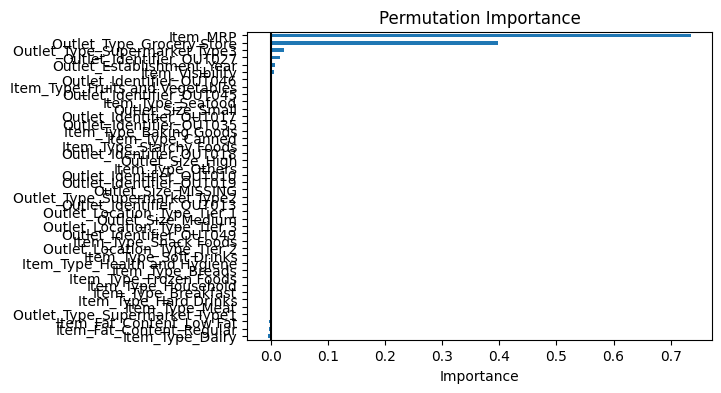

In [50]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(rf_perm_importances, title='Permutation Importance');

##Update your README

Insert your exported figures from above into your README file. You should have the following:

- Your LinearRegression coefficients plot.
  - Your interpretation of your coefficients.
- Your tree-based model's feature importances.
  - Your interpretation of your feature importance.
- Add final recommendations to your stakeholder.